# AST1420 - Assignment 2 
## Emaad Paracha - 1003687236

## 0. Importing Dependencies

In [1]:
import matplotlib.pyplot as plt
import math
from galpy.orbit import Orbit
from astropy import io
import astropy.units as u
import astropy.constants as const
from galpy import potential
from scipy import integrate
from scipy.integrate import odeint
from scipy.integrate import quad
from scipy.misc import derivative
from galpy.potential import MWPotential2014
from galpy.potential import NFWPotential
import numpy as np
from IPython.display import Image
import scipy.optimize as opt
from galpy.potential import evaluatePotentials
from scipy.spatial import ConvexHull
from matplotlib.collections import PolyCollection
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore") #Not ideal, I just wanted to make the notebook cleaner

## Question 1 - Dark matter and scaling relations in disk galaxies.
In one of the recent Q\&A sessions, we played with rotation curves
from the SPARC compilation (Lelli et al. 2016) and decomposed them
into disk and halo contributions. Let's see what else we can learn
about dark matter and galaxy structure from these data!

### Part a

When we did the exercise in class, we used disk rotation curves
that were unconstrained by other data. But we in fact have
surface-brightness measurements for all of the galaxies in the sample
(included in the table as SBdisk), which we can use to
determine an appropriate disk rotation curve and its contribution to
the total rotation curve. For the three galaxies that we studied in
class, re-fit the rotation curve as a razor-thin disk plus NFW halo,
but first finding good disk parameters by fitting the surface
brightness profile (assume $M/L = 1$ as is appropriate in the mid-IR
used in the SPARC compilation). You can just fit by hand and determine
parameters that roughly fit by eye.

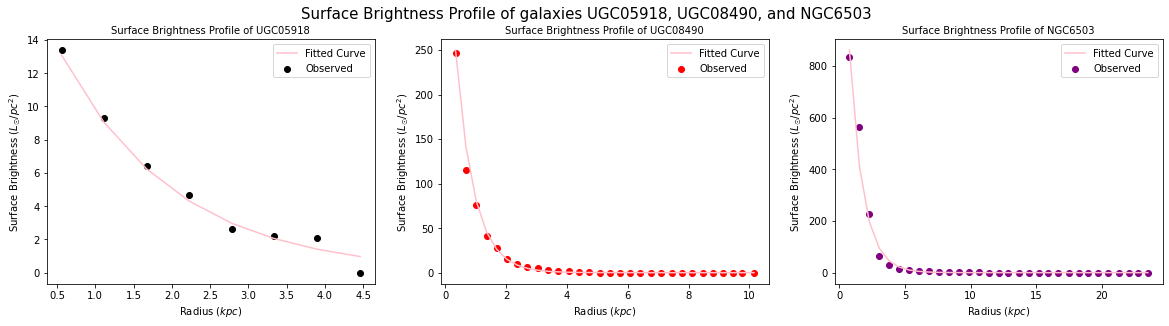

In [2]:
#Finding good disk parameters by fitting observed surface brightness profile to the razor thin disk potential

alldata = io.ascii.read('MassModels_Lelli2016c.mrt') #Importing data
threegalaxies = ['UGC05918','UGC08490','NGC6503'] #Setting names of the three galaxies

fittingamp = [19.,440.,1800.]*((u.Msun)/(u.pc**2)) #Parameters to fit
fittinghr = [1.5,0.6,1.03]*(u.kpc) #Parameters to fit

#Setting subplot configuration
fig, axs = plt.subplots(1, 3, figsize=(20,4.5))
colors = ['k','red','purple'] #Color list for graphs
i = 0 #Counter

#Plotting SBDisk vs Radii and fitting them
for galaxy in threegalaxies:
    
    table = alldata[alldata['ID'] == galaxy] #Setting the table to just be for that specific galaxy
    
    radii = table['R'].to(u.kpc) #Get list of radii (with units)
    sbdiskii = table['SBdisk'].to(u.Lsun/(u.pc**2)) #Get list of SBdisk (with units)
    
    disk = potential.RazorThinExponentialDiskPotential(amp=fittingamp[i],hr=fittinghr[i]) #Fit observed to razon thin disk
    surfacedensity = disk.surfdens(radii,0) #Since M/L = 1, get surface density

    fig.suptitle("Surface Brightness Profile of galaxies "+threegalaxies[0]+", "+threegalaxies[1]+", and "+threegalaxies[2],fontsize=15) #Main Title

    axs[i].scatter(radii,sbdiskii,color=colors[i],label="Observed") #Plotting the data in minigraphs
    axs[i].plot(radii,surfacedensity,color="pink",label="Fitted Curve")
    axs[i].set_title("Surface Brightness Profile of "+galaxy,fontsize=10) #Setting minigraph titles
    axs[i].set_xlabel("Radius ($kpc$)") #x-label
    axs[i].set_ylabel("Surface Brightness ($L_{☉}/pc^{2}$)") #y-label
    axs[i].legend() #Show legend
    
    i += 1 #Increasing Counter

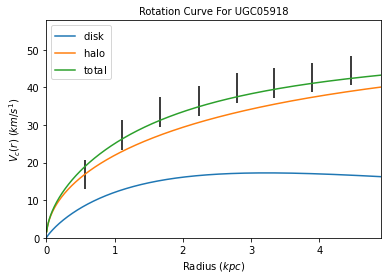

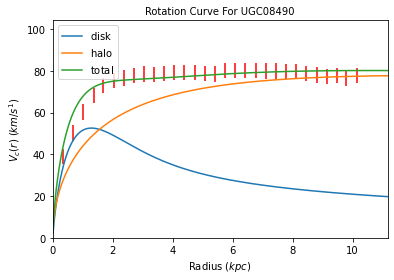

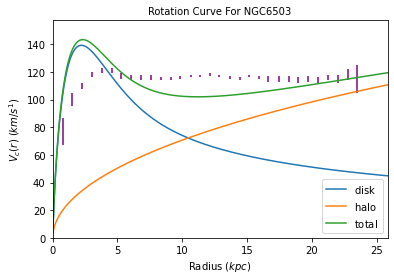

In [3]:
#Refitting rotation curve as razor thin disk + NFW halo with parameters found above

halo_mvir = [4.5e10,8.5e10,1.5e13]*(u.Msun) #Parameters to fit for halo virial mass
halo_conc = [10.,23.,2.] #Parameters to fit for halo concentration

i = 0 #Resetting counter

for galaxy in threegalaxies:
    
    table = alldata[alldata['ID'] == galaxy] #Setting the table to just be for that specific galaxy
    
    radii = table['R'].to(u.kpc) #Get list of radii (with units)
    Vobs = table['Vobs'].to(u.km/u.second) #Get list of observed circular velocity (with units)
    errorVobs = table['e_Vobs'].to(u.km/u.second) #Get list of error in the above observed circular velocity (with units)
        
    xarray_radius = np.array(radii)*u.kpc #Convert radii to numpy array
    xrange_radius = [0,1.1*xarray_radius.max()] #Create radius range
    
    disk = potential.RazorThinExponentialDiskPotential(amp=fittingamp[i],hr=fittinghr[i]) #Fit disk to razor thin potential
    halo = potential.NFWPotential(mvir=halo_mvir[i].to_value(1e12*u.Msun),conc=halo_conc[i],ro=8.,vo=220.) #Fit DM halo to NFW profile
        
    plt.xlim(0.,1.1*np.max(radii.value)) #Setting x-limit
    plt.ylim(0.,1.3*np.max(Vobs.value)) #Setting y-limit
    
    plt.errorbar(radii.value,Vobs.value,yerr=errorVobs.value,ls='none',color=colors[i]) #Plot error bars
    disk.plotRotcurve(Rrange=xrange_radius,overplot=True,label=r'$\mathrm{disk}$') #Plot disk rotation curve
    halo.plotRotcurve(Rrange=xrange_radius,overplot=True,label=r'$\mathrm{halo}$') #Plot halo rotation curve
    potential.plotRotcurve(disk+halo,Rrange=xrange_radius,overplot=True,label=r'$\mathrm{total}$') #Plot disk+halo total rotation curve

    plt.title("Rotation Curve For "+galaxy,fontsize=10) #Setting minigraph titles
    plt.xlabel("Radius ($kpc$)") #x-label
    plt.ylabel("$V_{c}(r)$ $(km/s^{1})$") #y-label
    plt.legend() #Show legend
    plt.show() #Show plot
    
    i += 1 #Increasing Counter

### Part b
What do you learn about the dark matter contribution in these
galaxies?

In all three rotation curves shown above, we see significant influence of dark matter on the rotational velocities of galaxies. For UGC05918, the dark matter halo contributes much more than the disk, from the center all the way out. For UGC08490, we can observe equal contribution to the rotational velocity near the center, however as we approach radii above 2kpc, we see DM halo's contribution outweight the disk's. Lastly, for NGC6503, we see the disk contributing much more than the halo near the center and all the way out to about 10-11kpc, after which contribution from the DM halo starts contributing more.

### Part c
The Tully-Fisher relation is a famous scaling relation for disk
galaxies that relates a galaxies asymptotic velocity $V_\infty$ to its
luminosity. It can be used, for example, to obtain distances to
galaxies, because the rotation velocity can be measured relatively
easily and the luminosity obtained from the relation can then be
combined with the observed magnitude to obtain the distance. It's also
a useful constraint on galaxy formation models. Let's use the
bulgeless SPARC galaxies to measure the Tully-Fisher relation
ourselves! To obtain a quantitative determination of $V_\infty$, we can
fit the rotation curves with a gravitational potential of the form

$$\phi(r) = {v_0^2\over 2}\,\ln\left(r^2 + r_0^2\right)$$

with two free parameters, $v_0$ and $r_0$. Determine the circular
velocity as a function of radius $v_c(r)$ for this potential. What is
$V_\infty$ in terms of $v_0$ and $r_0$?

We have the following gravitational potential:

$$\phi(r) = \frac{v_{0}^{2}}{2}\ln(r^{2} + r_{0}^{2})$$

To find $v_{c}(r)$ we need:

$$v_{c}(r) = \sqrt{r\frac{\partial \phi}{\partial r}}$$

For $\partial \phi/\partial r$, we have:

$$ \frac{\partial \phi}{\partial r} = \frac{v_{0}^{2} r}{r^{2} + r_{0}^{2}} $$

Plugging that into the equation for $v_{c}(r)$, we get:

$$ v_{c}(r) = \sqrt{\frac{v_{0}^{2} r^{2}}{r^{2} + r_{0}^{2}}}$$

Thus we get the formula for circular velocity $v_{c}(r)$ as a function of radius for this potential.

To get $V_{\infty}$, we can rewrite $v_{c}(r)$ as:

$$ v_{c}(r) = v_{0}\sqrt{\frac{1}{1 + \frac{r_{0}^{2}}{r^{2}}}}$$

Plugging in $r = \infty$, we see that the $r_{0}^{2}/r^{2}$ term goes to $0$ as $r \rightarrow \infty$. Thus, we simply get:

$$ V_{\infty} = v_{0} $$



### Part d
Now fit this model to all bulgeless SPARC galaxies. Fit the model rotation velocity by minimizing $\chi^2$ defined as


$$ \chi^2 = \sum_i {\left[v_c(\texttt{R}_i) - \texttt{Vobs}_i\right]^2 \over \texttt{eVobs}_i^2} $$


where $i$ indexes the $N$ data points for each galaxy
${R}_i,Vobs_i,eVobs_i$. You can use
scipy optimization functions for this. Compare the model fit
to the observed rotation curve for the three galaxies from part (a)
and do the fit for all 143 bulgeless galaxies.

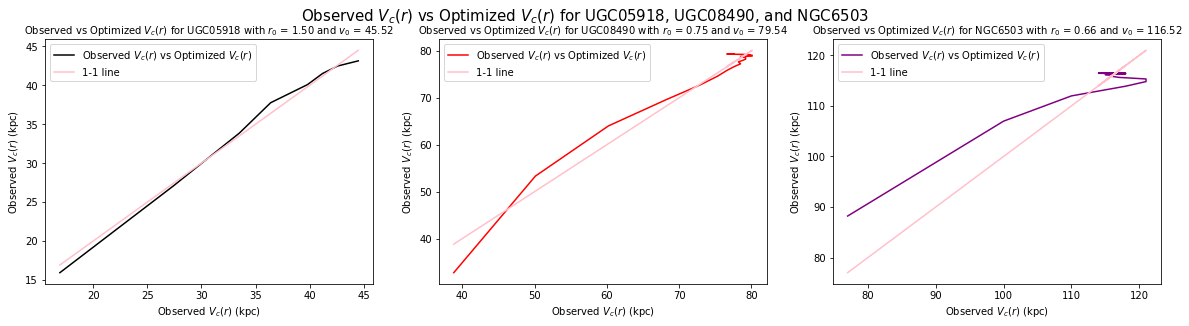

In [4]:
#Defining chi-squared function
def funx(params):
    r0, v0 = params #r0 and v0 parameters
    chisq = 0 #Set chisquare value to 0
    for x in range(len(chirad)):
        vcr = math.sqrt(((v0**2)*(chirad[x]**2))/((chirad[x]**2)+(r0**2))) #Get value for vcr based on calculations above
        chiopt = ((vcr - chiobs[x])**2)/(chierr[x]**2) #Get value of (vcr-vobs/error)^2
        chisq += chiopt #Add to chisquare value and rerun over all N data points
    return chisq #Return chisquare value

#Setting subplot configuration
fig, axs = plt.subplots(1, 3, figsize=(20,4.5))
i = 0 #Reset counter

#Finding best r0 and v0 and plotting for the three galaxies in part a
for galaxy in threegalaxies:
    table = alldata[alldata['ID'] == galaxy] #Setting the table to just be for that specific galaxy

    chirad = np.array(table['R']) #Radii array
    chiobs = np.array(table['Vobs']) #Observed rotational velocity array
    chierr = np.array(table['e_Vobs']) #Error in observed rotational velocity array

    guessr = 8. #r0 guess
    guessv = 200. #v0 guess
    guess = [guessr,guessv] #Setting initial guess

    result =  opt.minimize(funx, guess) #Get result of optimization
    optimizedr, optimizedv = result.x #Get r0 and v0 from optimization
    
    optvcr = [] #Defining optimized vcr list
    for rad in chirad:
        optvcr.append(math.sqrt(((optimizedv**2)*(rad**2))/((rad**2)+(optimizedr**2)))) #Append optimized vcr for each radius

    fig.suptitle("Observed $V_{c}(r)$ vs Optimized $V_{c}(r)$ for "+threegalaxies[0]+", "+threegalaxies[1]+", and "+threegalaxies[2],fontsize=15) #Main Title

    axs[i].plot(chiobs,optvcr,color=colors[i],label="Observed $V_{c}(r)$ vs Optimized $V_{c}(r)$") #Plot observed vcr vs optimized vct
    axs[i].plot(chiobs,chiobs,color="pink",label="1-1 line") #Plot 45-degree line to visually show how well the line is fit
    axs[i].set_title("Observed vs Optimized $V_{c}(r)$ for "+galaxy+" with $r_{0}$ = "+str("{:.2f}".format(optimizedr))+" and $v_{0}$ = "+str("{:.2f}".format(optimizedv)),fontsize=10) #Setting minigraph titles
    axs[i].set_xlabel("Observed $V_{c}(r)$ (kpc)") #x-label
    axs[i].set_ylabel("Observed $V_{c}(r)$ (kpc)") #y-label
    axs[i].legend() #Show legend
    
    i += 1 #Increment counter
    

In [5]:
#Finding fit for all bulge-less galaxies

uniquegal = set(alldata['ID']) #Get table of unique galaxies

bulgelessgal = [] #Define bulgeless galaxy array

for galax in uniquegal: #Finding bulgeless galaxies
    datatable = alldata[alldata['ID'] == galax] #Set table to that specific galaxy
    if np.all(np.fabs(datatable['Vbul']) < 1e-10): #If bulgeless, append to bulgeless array
        bulgelessgal.append(galax)
        
rzerolist = [] #Empty list of r0's
vzerolist = [] #Empty list of v0's
optimvcrlist = [] #Empty list of optimized V_c(r)
        
#Finding best r0 and v0 for all bulgeless galaxies
for galaxy in bulgelessgal:
    table = alldata[alldata['ID'] == galaxy] #Setting the table to just be for that specific galaxy

    chirad = np.array(table['R']) #Radii array
    chiobs = np.array(table['Vobs']) #Observed rotational velocity array
    chierr = np.array(table['e_Vobs']) #Error in observed rotational velocity array

    guessr = 8. #r0 guess
    guessv = 200. #v0 guess
    guess = [guessr,guessv] #Setting initial guess

    result =  opt.minimize(funx, guess) #Get result of optimization
    optimizedr, optimizedv = result.x #Get r0 and v0 from optimization
    
    optvcr = [] #Defining optimized vcr list
    for rad in chirad:
        optvcr.append(math.sqrt(((optimizedv**2)*(rad**2))/((rad**2)+(optimizedr**2)))) #Append optimized vcr for each radius
    
    rzerolist.append(optimizedr) #Append r0 to main list
    vzerolist.append(optimizedv) #Append v0 to main list
    optimvcrlist.append(optvcr) #Append list of optimized V_c(r) to main list

### Part e

Now derive the Tully-Fisher relation by computing the total
luminosity of each galaxy and plotting $V_\infty$ versus the total
luminosity. Discuss what you see. The Tully-Fisher relation is
generally well fit as $L \propto V_\infty^\alpha$; if you fit this form
to your obtained relation, what value for $\alpha$ do you get (you can
fit without taking errors into account). What $\alpha$ do you get if
you only include $L > 10^{10}\,L_\odot$ galaxies? Which of these two
determinations do you think is more accurate and why?

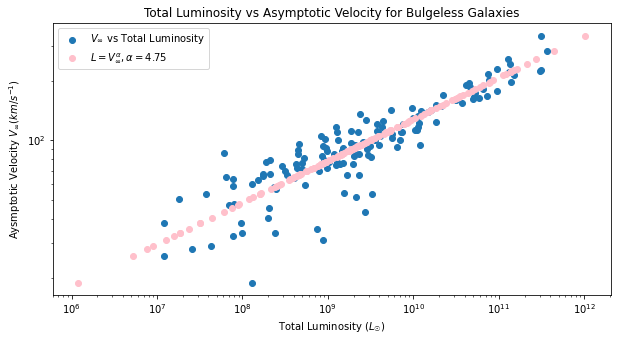

In [6]:
#Making total luminosity vs V_infinity graphs for all bulgeless galaxies

totallum = [] #Empty total luminosity array

for galaxy in bulgelessgal:
    table = alldata[alldata['ID'] == galaxy] #Setting the table to just be for that specific galaxy
    
    sbdisk = table['SBdisk'].to(u.Lsun/(u.pc**2)) #Get list of SBdisk (with units)
    radiis = table['R'].to(u.kpc) #Get radii (with units)
    radiispc = radiis.to(u.pc) #Convert radii to pc (to ensure units are correct)
    
    rangerad = [0,max(radiispc)] #Create range of radii to integrate over
    
    luminosity = integrate.simps(2*math.pi*radiispc*sbdisk,radiispc) #Integrate to get total luminosity
    totallum.append(luminosity) #append total luminosity to list

plt.figure(figsize=(10,5)) #Set plot size

plt.scatter(totallum,vzerolist,label="$V_{\infty}$ vs Total Luminosity") #Plot total luminosity vs V_infinity

alphav = [] #Set empty list for V^alpha_infinity
alpha = 4.75 #Setting alpha, I changed this according to the graph to fit it to the values
for l in vzerolist:
    alphav.append(l**alpha) #Create list of V^alpha_infinity
    
plt.scatter(alphav,vzerolist,color="pink",label="$L = V_{\infty}^{α}, α = 4.75$") #Plot total luminosity vs V^alpha_infinity
plt.xlabel("Total Luminosity $(L_{☉})$") #X-label
plt.ylabel("Aysmptotic Velocity $V_{\infty} (km/s^{-1})$") #Y-label
plt.xscale("log") #Setting x-scale to log
plt.yscale("log") #Setting y-scale to log
plt.title("Total Luminosity vs Asymptotic Velocity for Bulgeless Galaxies") #Plot title
plt.legend() #Show legend

plt.show()

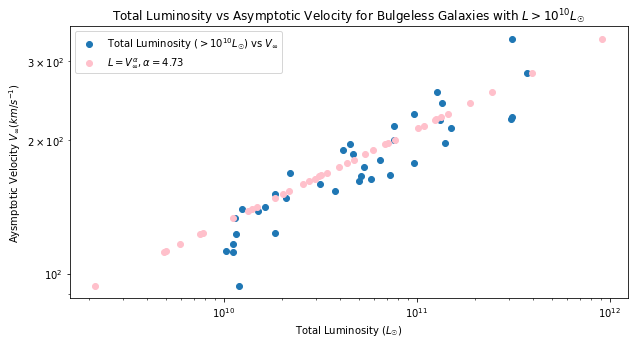

In [7]:
#Making total luminosity vs V_infinity graphs for all bulgeless galaxies with total luminosity greater than 10^10 Lsun

over10lum = [] #Create empty list of luminosities above 10e10 Lsun
over10v = [] #Create empty list of corresponding V_infinity
i = 0 #Counter
for gallum in totallum: #For each total luminosity,
    if (gallum > 1e10): #if the value is above 10e10,
        over10lum.append(gallum) #append it to the empty list of luminosities above 10e10 Lsun
        over10v.append(vzerolist[i]) #and correspondingly append the V_infinity to the new list
    else: #If not, then pass
        pass
    i += 1 #Increment counter

plt.figure(figsize=(10,5)) #Set plot size

plt.scatter(over10lum,over10v,label="Total Luminosity $(> 10^{10} L_{☉})$ vs $V_{\infty}$") #Plot total luminosities above 10^10 Lsun vs V_infinity

over10alphav = [] #Set empty list for V^alpha_infinity
over10alpha = 4.73 #Setting alpha, I changed this according to the graph to fit it to the values
for l in over10v:
    over10alphav.append(l**over10alpha) #Create list of V^alpha_infinity
    
plt.scatter(over10alphav,over10v,color="pink",label="$L = V_{\infty}^{α}, α = 4.73$") #Plot total luminosity vs V^alpha_infinity"
plt.xlabel("Total Luminosity $(L_{☉})$") #Set x-label
plt.ylabel("Aysmptotic Velocity $V_{\infty} (km/s^{-1})$") #Set y-label
plt.xscale("log") #Set x-scale
plt.yscale("log") #Set y-scale
plt.title("Total Luminosity vs Asymptotic Velocity for Bulgeless Galaxies with $L > 10^{10} L_{☉}$") #Plot title
plt.legend() #Show legend

plt.show()

As can be observed in the 2 graphs above, one for all bulgeless galaxies and the other for bulgeless galaxies with $L > 10^{10} L_{☉}$, we observe an overall increase in the asymptotic velocity, $V_{\infty}$, with an increase in total luminosity of a bulgeless galaxy. When we fit the graphs to obtain a relation of the sort $L \propto V_\infty^\alpha$, we see the graphs are best fit around $4.73 < \alpha < 4.75$, close to $\alpha = 4.75$ for all bulgeless galaxies in the SPARC dataset and close to $\alpha = 4.73$ for those bulgeless galaxies that have luminosity $L > 10^{10} L_{☉}$.

When trying to fit and find $\alpha$, I observed that $\alpha = 4.75$ (plotted for all bulgeless galaxies) was somewhat a more accurate fit for galaxies with total luminosities around $10^{8} - 10^{10} L_{☉}$, and for galaxies with higher luminosities, the best value I could observe for $\alpha$, $\alpha = 4.73$, was loosely able to follow the trend. This could either be a result of less data or numerical inaccuracies when minimizing $\chi^{2}$ in part d. But in both cases, the Tully-Fisher relation can be seen between the asymptotic velocities and total luminosities of these galaxies.

## Question 2 - The zero-velocity curve.
When we looked at orbits in disk galaxies, we discussed the
zero-velocity curve: the curve in the meridional plane $(R,z)$ where
$v_R = v_z = 0$. Let's explore this important curve further!

### Part a
For the example orbit in Chapter 10.1, we showed
the zero-velocity curve as a constant energy contour, but we could
also explicitly compute $z$ as a function of $(R,E,L_z)$ on the
zero-velocity curve by demanding that $v_R = v_z = 0$. Do this for the
first example orbit in Chapter 10.1 and compare to the zero-velocity
curve that you get from the contouring method.

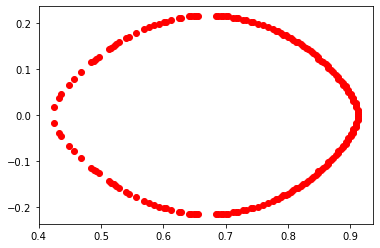

In [8]:
#Setting values for E and Lz
E = -1.25 
Lz = 0.6

#Creating function for effective potential
def phieff(rvalue,zvalue):
    return evaluatePotentials(potential.MWPotential2014, rvalue, zvalue) + ((Lz**2)/(2*(rvalue**2)))

#Setting arrays of z and r points
Z = np.linspace(-4,4,2000)
R = np.linspace(0,8,2000)

solutionset = [] #Empty solution set array

#Finding r,z pairs that (roughly) yield 0 for (Effective Potential - E)
for r in R:
    for z in Z:
        if (abs(phieff(r,z)-E) < 1e-3):
            solutionset.append([r,z]) #Appending those pairs to the solution set
        else:
            pass   
        
solutionz = []
solutionr = []
#Separating z's and r's
for s in solutionset:
    solutionr.append(s[0])
    solutionz.append(s[1])
    
plt.scatter(solutionr,solutionz,color="red") #Plotting the solution set to make sure it is correct
plt.show()

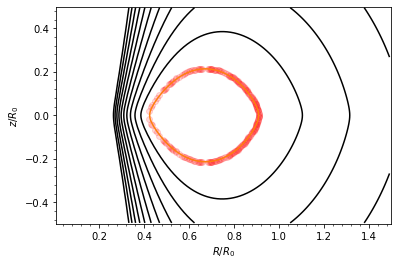

In [9]:
#Code from example in 10.1 in class notes to plot contour lines
E, Lz= -1.25, 0.6
levels= np.linspace(-1.25,0.,11)
cntrcolors= ['k' for l in levels]
cntrcolors[np.arange(len(levels))\
           [np.fabs(levels-E) < 0.01][0]]= '#ff7f0e'
potential.plotPotentials(potential.MWPotential2014,
                         rmin=.01,nrs=101,nzs=101,
                         justcontours=True,
                         levels=levels,
                         cntrcolors=cntrcolors,
                         effective=True,
                         Lz=Lz);

#Plotting the solution set computed above ontop of the zero-velocity curve to ensure they match
#(which they do!)
plt.scatter(solutionr,solutionz,color="red",alpha=0.15)
plt.show()

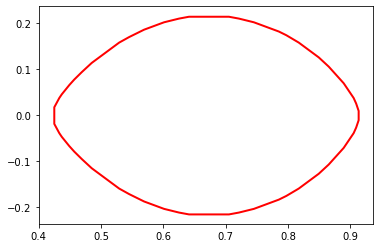

In [10]:
#Another way to visualize is to connect the outer points of the solution set using this method! 
#Not really required but something cool!

fig, ax = plt.subplots()
length = len(solutionz)

points = np.concatenate([solutionr,solutionz]).reshape((2,length)).T
hull = ConvexHull(points)

ax.scatter(solutionr,solutionz,color="red",alpha=0)

ax.add_collection(PolyCollection([points[hull.vertices,:]], edgecolors='r',facecolors='w',linewidths=2,zorder=-1))
plt.show()

As can be observed in the plots above, the $z$ values on the zero-velocity curve were successfully computed for corresponding $R$, $E$, and $L_z$ values.

### Part b
In the notes, we discussed how orbits touch the
zero-velocity curve at four points, but there are orbits at a given
$(E,L_z)$ that only touch the zero-velocity curve at two
points. These orbits are called the thin tubes, because in 3D they
look like a tube (that's thin!). Devise an algorithm to find this
orbit for a given $(E,L_z)$ and apply it to the $(E,L_z)$ of the
example orbit in (a) (there are various, qualitatively different ways to do this; explain why your algorithm works in general). Show the
orbit in $(R,z)$ and $(x,y,z)$? Discuss what you think is interesting
about this orbit.


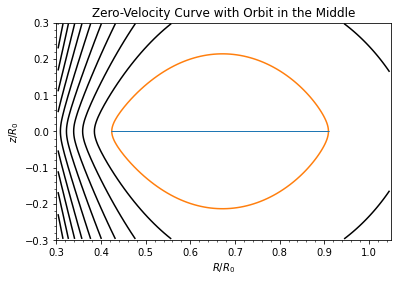

In [11]:
#Code for orbit from notes in Chapter 10
def orbit_RvRELz(R,vR,E,Lz,pot=None):
    """Returns Orbit at (R,vR,phi=0,z=0) with given (E,Lz)"""
    return Orbit([R,vR,Lz/R,0.,
                  np.sqrt(2.*(E-potential.evaluatePotentials(pot,R,0.)
                                 -(Lz/R)**2./2.-vR**2./2)),0.],ro=8.,vo=220.)

#We have vZ = np.sqrt(2.*(E-potential.evaluatePotentials(pot,R,0.)-(Lz/R)**2./2.-vR**2./2))
#So we want such a vR that vZ = 0, so we don't get any movement in the z direction. Thus we would get a "tube" that touches the zero velocity curve only twice

pot = potential.MWPotential2014 #Defining the potential

def twotouch(R,E,Lz,pot): #Defining two touch algorithm

    vR= math.sqrt(2*(E-potential.evaluatePotentials(pot,R,0.) - ((Lz/R)**2./2.))) #Computing vR such that vZ ends up being 0

    o= orbit_RvRELz(R,vR,E,Lz,pot=pot) #Initialize Orbit
    ts= np.linspace(0.,100.,1001) #Timesteps
    o.integrate(ts,pot) #Integrate orbit
    
    #Code for the contour lines from the notes
    levels= np.linspace(E,0.,11)
    cntrcolors= ['k' for l in levels]
    cntrcolors[np.arange(len(levels))\
           [np.fabs(levels-E) < 0.01][0]]= '#ff7f0e'
    potential.plotPotentials(pot,
                         rmin=0.3,rmax=1.05,
                         zmin=-0.3,zmax=0.3,
                         nrs=101,nzs=101,
                         justcontours=True,
                         levels=levels,
                         cntrcolors=cntrcolors,
                         effective=True,
                         Lz=Lz)
    

    o.plot(overplot=True,lw=0.5,use_physical=False) #Plotting orbit on contour lines
    plt.title("Zero-Velocity Curve with Orbit in the Middle")
    plt.show()
    return o #Return orbit

orbitting = twotouch(0.5, -1.25, 0.6, pot) #Give orbit with the same parameters, but now only touching the zero-velocity curve twice

In [12]:
#Animation of the orbit showing it has no z-component
orbitting.animate(staticPlot=True) 

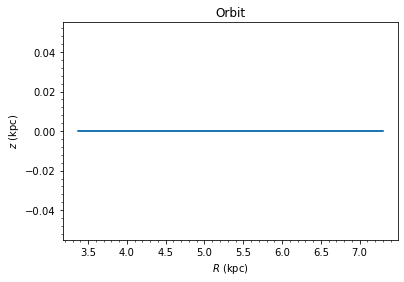

In [13]:
#Orbit plot in (R,z)
orbitting.plot()
plt.title("Orbit")
plt.show()

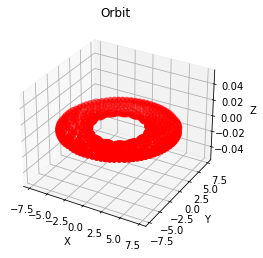

In [14]:
#Plotting orbit in (x,y,z)

orbitx = [] #Defining empty array for x-values
orbity = [] #Defining empty array for y-values
orbitz = [] #Defining empty array for z-values

times = np.linspace(0.,100.,1001) #Timesteps

#Getting the x, y, and z values
for tim in times:
    orbitx.append(orbitting(tim).x())
    orbity.append(orbitting(tim).y())
    orbitz.append(orbitting(tim).z())

#Configure 3D graph
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(orbitx, orbity, orbitz, c='r')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title("Orbit")

plt.show()

As was explained in the comments in the first code block for this part, vZ in the orbit initialization was dependent on $E, L_z, R$, and vR, and we needed to find a way to bring that to 0, so there would be no movement of the orbit in the $z$ direction. Thus, the formula for vR was set in a way to ensure we get vZ = 0. This way, the orbit would touch the zero-velocity curve only twice, since it does not have any $z$ component. This was further verified in the orbit plots. Interestingly, when the orbit was plotted in 3D in $(x,y,z)$ coordinates, we can observe it is a flat 2D annulus (or 2D disk) with symmetric-looking orbits that do not cross through the center/origin of the annulus. This annulus has no thickness in the z-direction, which is consistent with the plots above showing that it touches the zero-velocity curve only twice and the flat line at $z = 0$ for the orbit.